In [3]:
import numpy as np
import scipy.signal
import scipy.io
import matplotlib.pyplot as plt
import matplotlib
import math
import scipy.optimize
import pandas as pd
from IPython.display import Audio
import csv

In [4]:
def get_envelope(t, x, d=1):
    def hl_envelopes_idx(s, dmin=1, dmax=1, split=False):
        """
        Input :
        s: 1d-array, data signal from which to extract high and low envelopes
        dmin, dmax: int, optional, size of chunks, use this if the size of the input signal is too big
        split: bool, optional, if True, split the signal in half along its mean, might help to generate the envelope in some cases
        Output :
        lmin,lmax : high/low envelope idx of input signal s
        """

        # locals min
        lmin = (np.diff(np.sign(np.diff(s))) > 0).nonzero()[0] + 1
        # locals max
        lmax = (np.diff(np.sign(np.diff(s))) < 0).nonzero()[0] + 1

        if split:
            # s_mid is zero if s centered around x-axis or more generally mean of signal
            s_mid = np.mean(s)
            # pre-sorting of locals min based on relative position with respect to s_mid
            lmin = lmin[s[lmin] < s_mid]
            # pre-sorting of local max based on relative position with respect to s_mid
            lmax = lmax[s[lmax] > s_mid]

        # global min of dmin-chunks of locals min
        lmin = lmin[
            [i + np.argmin(s[lmin[i : i + dmin]]) for i in range(0, len(lmin), dmin)]
        ]
        # global max of dmax-chunks of locals max
        lmax = lmax[
            [i + np.argmax(s[lmax[i : i + dmax]]) for i in range(0, len(lmax), dmax)]
        ]

        return lmin, lmax

    _, lmax = hl_envelopes_idx(x, dmax=d)
    lmax = np.interp(t, t[lmax], x[lmax])
    return lmax

def nextpow2(N):
    n = 1
    while n < N:
        n *= 2
    return n

le signal commence à 0.21052083333333332 s
niveau de silence: -48.63 dB (0.00 V)
le signal finit à 0.5105208333333333
le signal commence à 0.1198125 s
niveau de silence: -3.07 dB (0.70 V)
le signal finit à 0.4198125
le signal commence à 0.26675 s
niveau de silence: -7.03 dB (0.44 V)
le signal finit à 0.56675
le signal commence à 0.16158333333333333 s
niveau de silence: -3.48 dB (0.67 V)
le signal finit à 0.46158333333333335
(4, 2097153)
(4, 2097153)


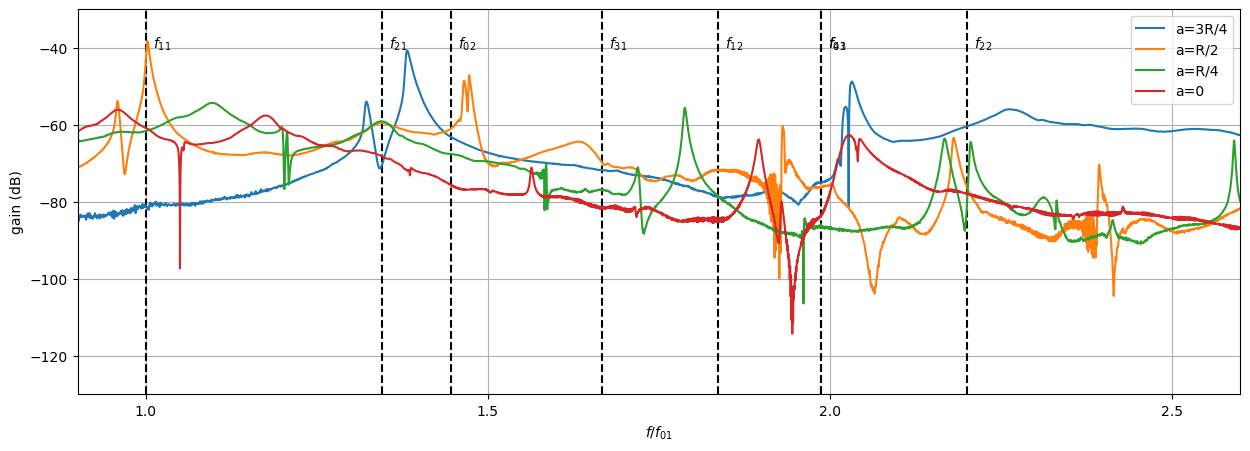

In [14]:
f1s = [66, 91, 111, 127]
ensembles = ["a=3R/4", "a=R/2", "a=R/4", "a=0"]
sigs = []
for f1, ensemble,i in zip(f1s, ensembles, np.arange(4)):
    filename = f"timbale-migrave-{i+1}.wav"
    fs, sig = scipy.io.wavfile.read(filename)
    sig = sig.astype(np.float32)
    sig /= np.max(abs(sig))
    t = np.arange(len(sig)) / fs
    env = get_envelope(t, sig)

    MARGE_START_BEFORE = int(0.01 * fs)
    MARGE_START_AFTER = int(0.1 * fs)
    MARGE_SEARCH_END = int(0.2 * fs)
    MARGE_SEARCH_END = int(0.2 * fs)
    MARGE_SILENCE = -0.01

    i_silence = np.argmax(abs(sig)) - MARGE_START_BEFORE
    print(f"le signal commence à {i_silence/fs} s")
    silence_level = np.max(abs(sig[:i_silence]))
    print(
        f"niveau de silence: {20*np.log10(silence_level):.2f} dB ({silence_level:.2f} V)"
    )

    t = np.arange(len(sig)) / fs
    i_start = i_silence + MARGE_START_AFTER

    i_searchend = i_start + MARGE_SEARCH_END
    i_end = i_searchend + np.argmax(env[i_searchend:] < silence_level + MARGE_SILENCE)
    print("le signal finit à", i_end / fs)
    
    sig = sig[i_silence:]
    sigs.append(sig)


l = max(len(s) for s in sigs)
for i in range(len(sigs)):
    sigs[i] = np.pad(sigs[i], (0, l-len(sigs[i])))
sigs=np.array(sigs)

N = 8 * nextpow2(l)
ffts = np.fft.rfft(sigs, N, axis=1) / l
freq =np.fft.rfftfreq(N, 1/fs)
freq = np.stack((freq, freq, freq, freq))
for i in range(freq.shape[0]):
    freq[i] /= f1s[i]

print(ffts.shape)
print(freq.shape)

beta_mn_fac = np.array([
    [0, 1, 2.30, 3.16], #0n
    [0, 1.59, 2.92, 0], #1n
    [0, 2.14, 3.5, 0], #2n
    [0, 2.65, 0, 0], #3n
    [0, 3.16, 0, 0] # 4n
])

plt.figure(figsize=(15, 5))

for m in range(0,beta_mn_fac.shape[0]):
    for n in range(1,beta_mn_fac.shape[1]):
        f = beta_mn_fac[m, n] / beta_mn_fac[1,1]
        plt.axvline(f, linestyle="--", color="black")
        plt.annotate(
            "$f_{" + str(m) + str(n) + "}$", (f + 0.01, -40)
        )


for i in range(4):
    plt.plot(freq[i], 20 * np.log10(abs(ffts[i])), label=ensembles[i])

plt.xlabel("$f$")
# plt.xscale('symlog')
plt.xlim(20,2000)
plt.ylim(-130, -30)
plt.grid(which="both")
plt.ylabel("gain (dB)")
plt.legend(loc="best")
plt.savefig("timbale-position-frappe.png")
plt.show()
plt.close("all")


le signal commence à 0.047875 s
niveau de silence: -10.00 dB (0.32 V)
le signal finit à 0.347875
le signal commence à 0.21052083333333332 s
niveau de silence: -48.63 dB (0.00 V)
le signal finit à 0.5105208333333333
le signal commence à 0.15891666666666668 s
niveau de silence: -49.28 dB (0.00 V)
le signal finit à 0.45891666666666664
le signal commence à 0.083625 s
niveau de silence: -38.40 dB (0.01 V)
le signal finit à 0.383625
(4, 2097153)
(4, 2097153)


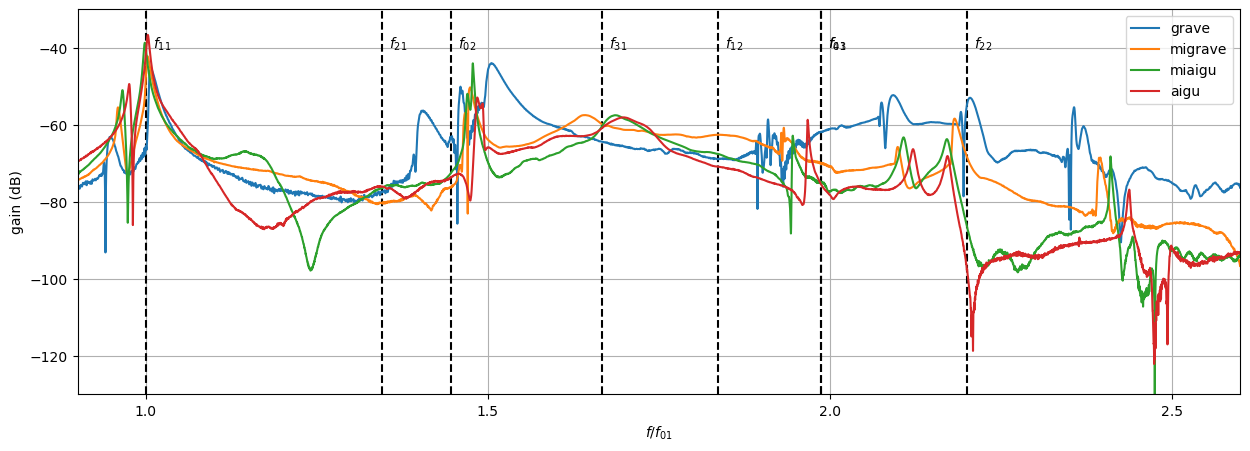

In [13]:
f1s = [66, 91, 111, 127]
ensembles = ["grave", "migrave", "miaigu", "aigu"]
sigs = []
for f1, ensemble in zip(f1s, ensembles):
    filename = f"timbale-{ensemble}-1.wav"
    fs, sig = scipy.io.wavfile.read(filename)
    sig = sig.astype(np.float32)
    sig /= np.max(abs(sig))
    t = np.arange(len(sig)) / fs
    env = get_envelope(t, sig)

    MARGE_START_BEFORE = int(0.01 * fs)
    MARGE_START_AFTER = int(0.1 * fs)
    MARGE_SEARCH_END = int(0.2 * fs)
    MARGE_SEARCH_END = int(0.2 * fs)
    MARGE_SILENCE = -0.01

    i_silence = np.argmax(abs(sig)) - MARGE_START_BEFORE
    print(f"le signal commence à {i_silence/fs} s")
    silence_level = np.max(abs(sig[:i_silence]))
    print(
        f"niveau de silence: {20*np.log10(silence_level):.2f} dB ({silence_level:.2f} V)"
    )

    t = np.arange(len(sig)) / fs
    i_start = i_silence + MARGE_START_AFTER

    i_searchend = i_start + MARGE_SEARCH_END
    i_end = i_searchend + np.argmax(env[i_searchend:] < silence_level + MARGE_SILENCE)
    print("le signal finit à", i_end / fs)
    
    sig = sig[i_silence:]
    sigs.append(sig)


l = max(len(s) for s in sigs)
for i in range(len(sigs)):
    sigs[i] = np.pad(sigs[i], (0, l-len(sigs[i])))
sigs=np.array(sigs)

print(ffts.shape)
print(freq.shape)

beta_mn_fac = np.array([
    [0, 1, 2.30, 3.16], #0n
    [0, 1.59, 2.92, 0], #1n
    [0, 2.14, 3.5, 0], #2n
    [0, 2.65, 0, 0], #3n
    [0, 3.16, 0, 0] # 4n
])

plt.figure(figsize=(15, 5))

for m in range(0,beta_mn_fac.shape[0]):
    for n in range(1,beta_mn_fac.shape[1]):
        f = beta_mn_fac[m, n] / beta_mn_fac[1,1]
        plt.axvline(f, linestyle="--", color="black")
        plt.annotate(
            "$f_{" + str(m) + str(n) + "}$", (f + 0.01, -40)
        )


for i in range(4):
    plt.plot(freq[i], 20 * np.log10(abs(ffts[i])), label=ensembles[i])

plt.xlabel("$f/f_{01}$")
# plt.xscale('symlog')
plt.xticks(np.arange(1,20)/2)
plt.xlim(0.9,2.6)
plt.ylim(-130, -30)
plt.grid(which="both")
plt.ylabel("gain (dB)")
plt.legend(loc="best")
plt.savefig("comparaison-harmo-timbale.png")
plt.show()
plt.close("all")
